In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("asaniczka/uk-optimal-product-price-prediction")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.
Path to dataset files: C:\Users\tlili\.cache\kagglehub\datasets\asaniczka\uk-optimal-product-price-prediction\versions\3


In [3]:
import os

# List files in the dataset directory
files = os.listdir(path)
print("Files in dataset directory:", files)

# Find the CSV file and read it
csv_files = [f for f in files if f.endswith('.csv')]
if csv_files:
	csv_path = os.path.join(path, csv_files[0])
	df = pd.read_csv(csv_path)
	df.info()
else:
	print("No CSV file found in the dataset directory.")

Files in dataset directory: ['amz_uk_price_prediction_dataset.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


In [4]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

In [5]:
pd.crosstab(df["category"], df["isBestSeller"])

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [6]:
bestseller_proportion = pd.crosstab(df["category"], df["isBestSeller"], normalize="index")

bestseller_proportion = bestseller_proportion[True].sort_values(ascending=False)
bestseller_proportion

category
Grocery                           0.058135
Smart Home Security & Lighting    0.057692
Health & Personal Care            0.057686
Mobile Phone Accessories          0.042471
Power & Hand Tools                0.035339
                                    ...   
Power Supplies                    0.000000
Ski Helmets                       0.000000
Ski Goggles                       0.000000
Snowboard Boots                   0.000000
eBook Readers & Accessories       0.000000
Name: True, Length: 296, dtype: float64

# the categories Grocery , Smart Home Security & Lighting and Health & Personal Care are more likely to have bestsellers

In [7]:
#Statistical Tests
from scipy.stats import chi2_contingency

In [8]:
crosstab_result=pd.crosstab(df["category"], df["isBestSeller"])
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [9]:
# Chi-square test for 'isbestseller' and 'category'
_, chi2_pvalue, _, _  = chi2_contingency(crosstab_result)

In [10]:
a,b,c,d=chi2_contingency(crosstab_result)

In [11]:
type(chi2_pvalue)

numpy.float64

In [12]:
float(chi2_pvalue)

0.0

float(chi2_pvalue) < 0.05

H₀: The two categorical variables are independent.
(There is no association between them.)
The null hypothesis of the Chi-square test is that the two categorical variables are independent. Given the extremely low \( p \)-value, we reject the null hypothesis. This implies that there's a significant association between `category` and `isbestseller` in the dataset.


In [13]:
from scipy.stats.contingency import association

In [14]:
association(crosstab_result, method='cramer')

0.1222829439760564

#according to the Cramér’s V Interpretation Guide (Cohen's Conventions) there is a weak association between the category and isbestseller

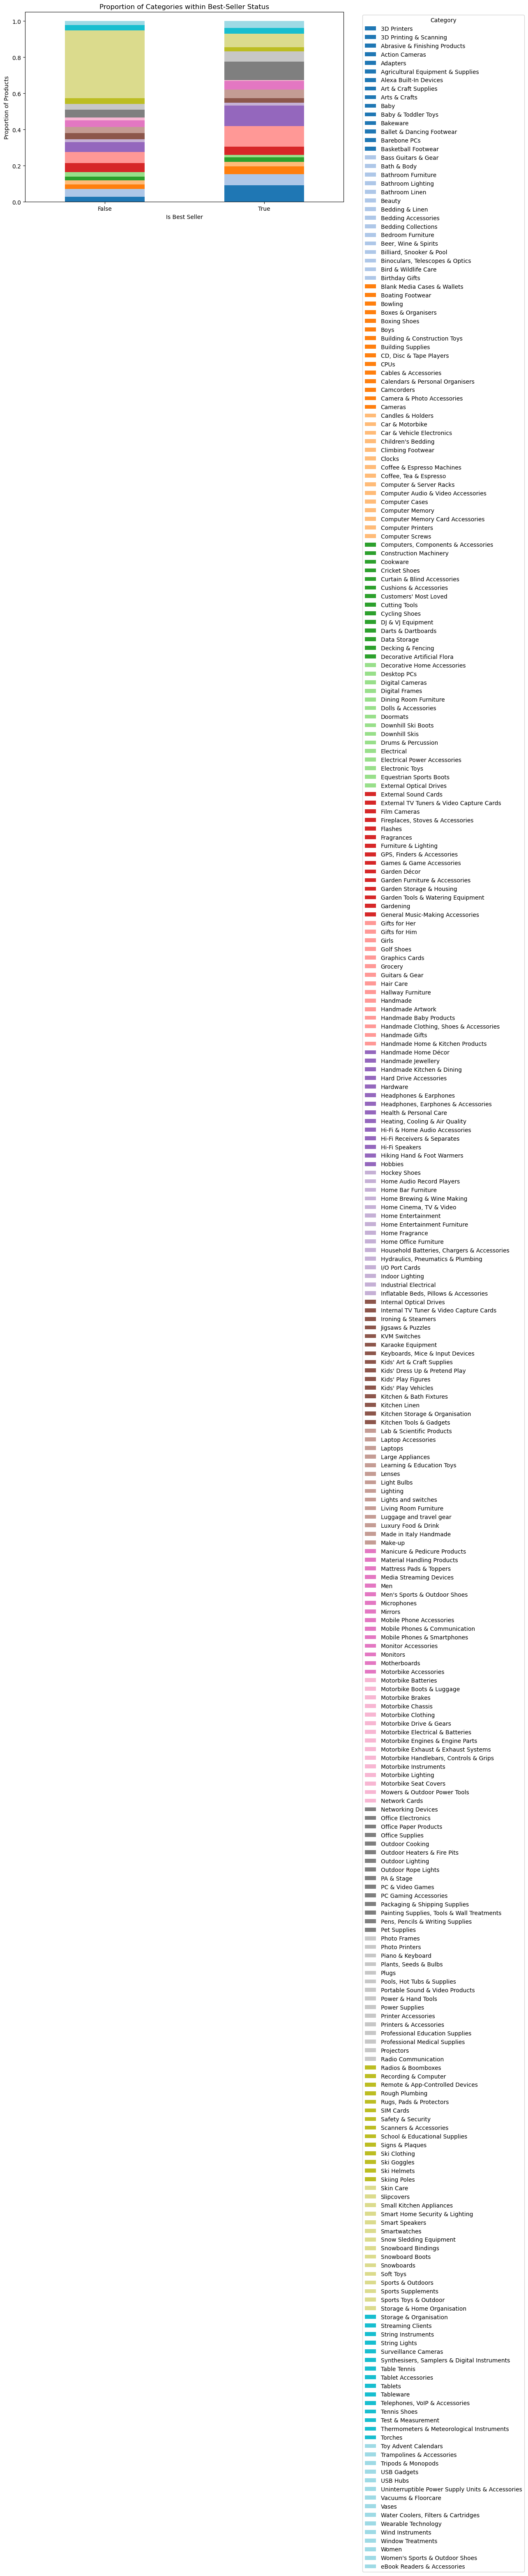

In [15]:
#Visualizations
ct = pd.crosstab(df["isBestSeller"], df["category"], normalize="index")

ct.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20")
plt.title("Proportion of Categories within Best-Seller Status")
plt.xlabel("Is Best Seller")
plt.ylabel("Proportion of Products")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

In [16]:
#Preliminary Step: define the outliers and remove them
def remove_outliers(df, column):
    """
    Remove outliers from a specific numeric column using the IQR method.
    Returns a cleaned df
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

   
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

   
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    print(f"{column}: removed {len(df) - len(df_clean)} outliers.")
    return df_clean

In [17]:
remove_outliers(df,"price")

price: removed 327688 outliers.


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


C:\Users\tlili\AppData\Local\Temp\ipykernel_9384\4095721917.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top_20, x="price", y="category", palette="coolwarm")


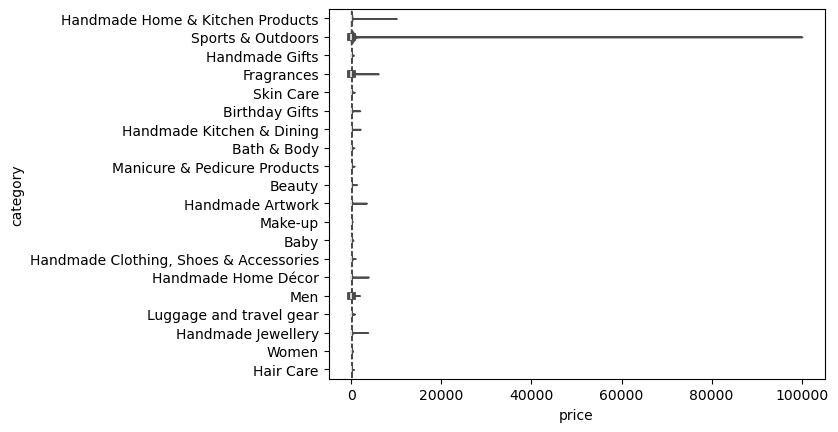

In [18]:
#filter 
top_20_categories=df["category"].value_counts().head(20)
df_top_20 = df[df["category"].isin(top_20_categories.index)]
df_top_20
sns.violinplot(data=df_top_20, x="price", y="category", palette="coolwarm")
plt.show()



#the category sport and outdoor tends to have the highest median price

In [19]:
# Step 1: Get the top 10 categories by count
top_10_categories = df["category"].value_counts().head(10).index

In [20]:
# Step 2: Filter the dataframe for these top 10 categories
df_top_10 = df[df["category"].isin(top_10_categories)]

In [21]:
# Step 3: Calculate average price per category
avg_price_per_category = df_top_10.groupby("category")["price"].mean().sort_values(ascending=False)


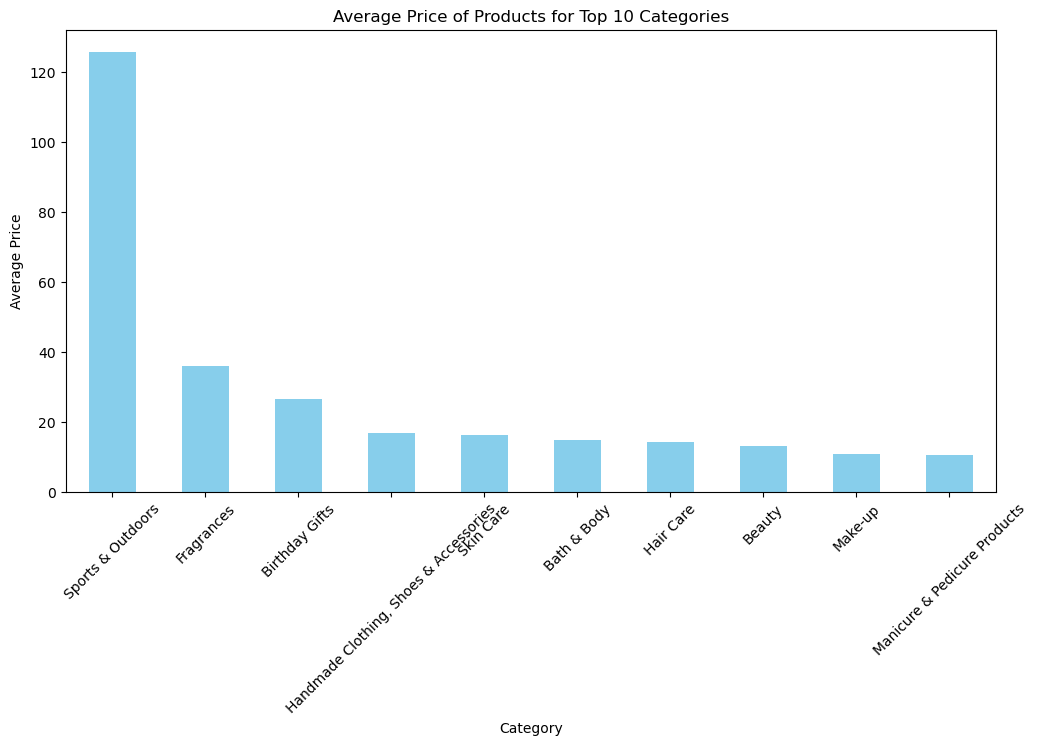

In [22]:
# Step 4: Plot the bar chart
plt.figure(figsize=(12,6))
avg_price_per_category.plot(kind='bar', color='skyblue')
plt.title("Average Price of Products for Top 10 Categories")
plt.ylabel("Average Price")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.show()

## the Sport and outdoors category has the highest average price in the top 10  categories 

### Part 3: Investigating the Interplay Between Product Prices and Ratings

In [28]:
# Correlation Coefficients
correlation = df['price'].corr(df['stars'])

print("Correlation coefficient between price and stars:", correlation)

Correlation coefficient between price and stars: -0.12490673262148641


##### there is a negative correlation between the price and rating 

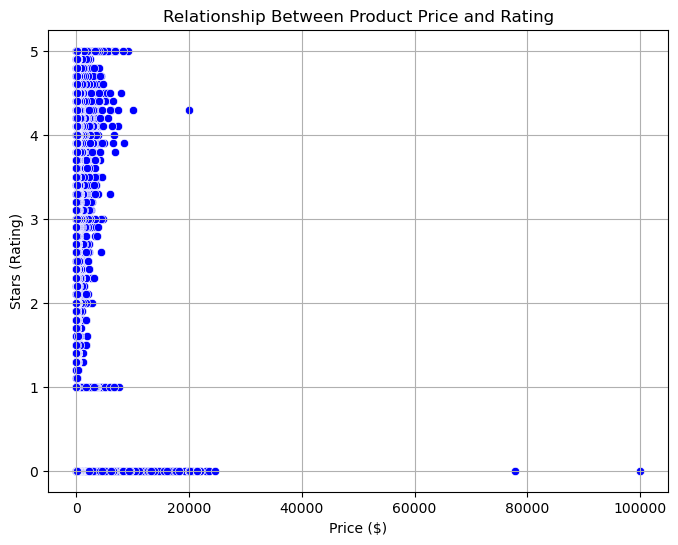

In [34]:
# Visualizations
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='stars', data=df , color='blue')
plt.title("Relationship Between Product Price and Rating")
plt.xlabel("Price ($)")
plt.ylabel("Stars (Rating)")
plt.grid(True)
plt.show()

In [40]:
# Select only numerical columns
numeric_df = df.select_dtypes(include=['number'])

# Drop uid before computing correlations
numeric_data = numeric_df.drop(columns=['uid'])

# Display the new DataFrame
print(numeric_data)

         stars  reviews  price  boughtInLastMonth
0          4.7    15308  21.99                  0
1          4.7    98099  23.99                  0
2          4.7    15308  21.99                  0
3          4.7     7205  31.99                  0
4          4.6     1881  17.99                  0
...        ...      ...    ...                ...
2443646    0.0        0  22.34                  0
2443647    0.0        0  97.99                  0
2443648    0.0        0  52.99                  0
2443649    4.3      404  79.99                  0
2443650    4.5       34  53.99                  0

[2443651 rows x 4 columns]


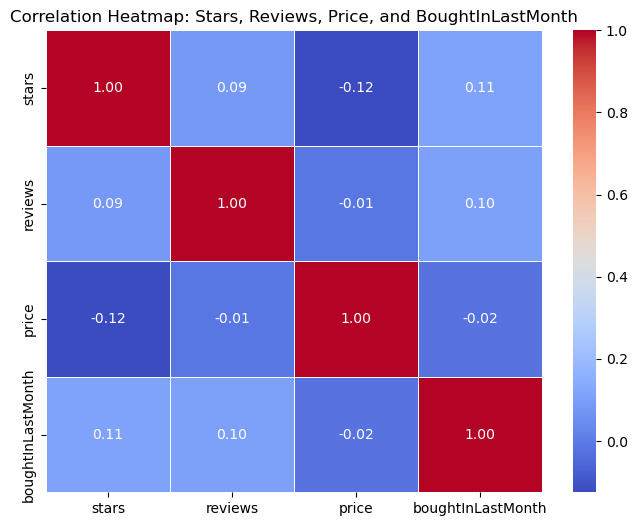

In [43]:
# Compute correlation matrix
corr = numeric_data.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title("Correlation Heatmap: Stars, Reviews, Price, and BoughtInLastMonth")
plt.show()

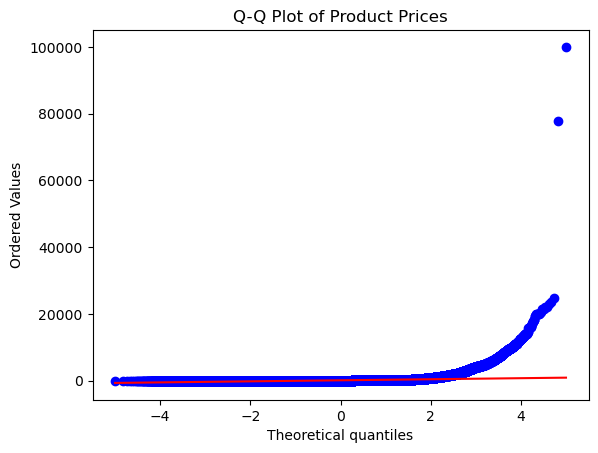

In [45]:
import scipy.stats as stats

# Create the QQ plot for 'price'
stats.probplot(numeric_data['price'], dist='norm', plot=plt)
plt.title("Q-Q Plot of Product Prices")
plt.show()

the points curve away from the red line especially at the end , the distribution is skewed